In [1]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.response import *
from lib.preferences import *

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
import seaborn as sns

import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style("white")

plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["font.size"] = 12

## Preference

In [3]:
analysis_metrics = ["HX", "VX", 
                    'frac_mixed_samples','mean_k',
                    'n_segregating','pi','theta',
                    'avg_frac_ibd', 'avg_n_ibd','avg_l_ibd']

In [4]:
genetic_names.update({
    "mean_k": "C.O.I ($k$)",
    "pi": "Nucl. Diversity ($\pi$)",
    "avg_l_ibd": "Avg. IBD\nTrack Length (bp)"
})

In [5]:
cols = [sns.color_palette("Blues", 6)[4], 
        sns.color_palette("Reds", 6)[4],
        sns.color_palette("Greens", 6)[4]]

## Load data

### Individual simulation

In [6]:
sim_ix = 0
expt = "ins"
temp = "../results/2020-06-07_intv-%s"

In [7]:
expt_path = temp % expt
sim_complete = [s for s in os.listdir(expt_path) 
                if "Endpoint" in os.listdir(os.path.join(expt_path, s))]
n_sims = len(sim_complete)

sim = sim_complete[sim_ix]

# Load full data frame
epoch_df = pd.read_csv(os.path.join(expt_path, sim, "epoch_df.csv"))
epoch_df.index = epoch_df.name
og = pd.read_csv(os.path.join(expt_path, sim, "og.csv"))
op = pd.read_csv(os.path.join(expt_path, sim, "op.csv"))

# Merge on time
ot = pd.merge(left=op, right=og, on="t0")

# Compute statistics
d = calc_detection_time(ot, epoch_df, 
                        initial_epoch="InitVar", 
                        respond_epoch="Crash", 
                        robustness=3, alpha=0.01,
                        analysis_metrics=analysis_metrics)

e = calc_equilibrium_time(ot, epoch_df,
                          initial_epoch="InitVar", 
                          respond_epoch="Crash",
                          equilibrium_epoch="CrashVar",
                          robustness=6,
                          analysis_metrics=analysis_metrics)

### Average

In [8]:
avg_path = expt_path.replace("results", "analysis")

# Load full data
epoch_df = pd.read_csv(os.path.join(avg_path, "epoch_df.csv"))
epoch_df.index = epoch_df.name
op_mu = pd.read_csv(os.path.join(avg_path, "ops_mean.csv"))
op_se = pd.read_csv(os.path.join(avg_path, "ops_se.csv"))
og_mu = pd.read_csv(os.path.join(avg_path, "ogs_mean.csv"))
og_se = pd.read_csv(os.path.join(avg_path, "ogs_se.csv"))

# Merge
ot_mu = pd.merge(left=op_mu, right=og_mu, on="t0")
ot_se = pd.merge(left=op_se, right=og_se)

## Visualize

### Prevalence, full

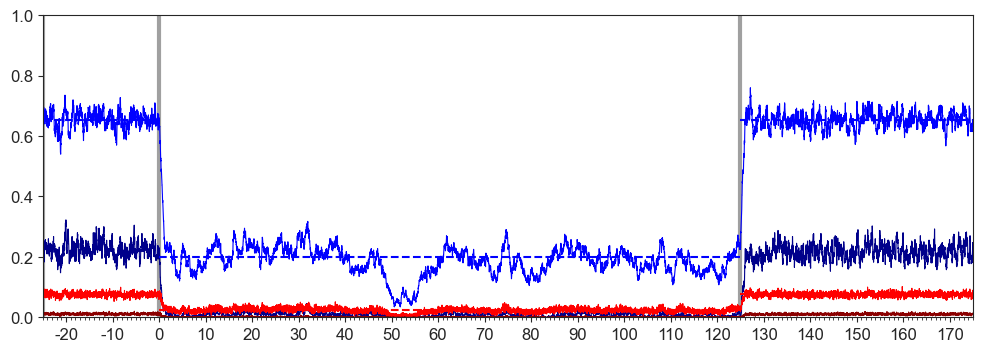

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

prevalence_trajectory_plot(ot, epoch_df, ax,
                           norm_t0=("Crash", "t0"),
                           indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("Recovery", "t0")],
                           indicate_equilibriums=["InitVar", "Crash", "CrashVar", "Recovery"],
                           time_limits=(epoch_df.loc["InitVar", "t0"], epoch_df.loc["Recovery", "t0"] + 50*365),
                           years_per_major_tick=10)

### Prevalence, Crash

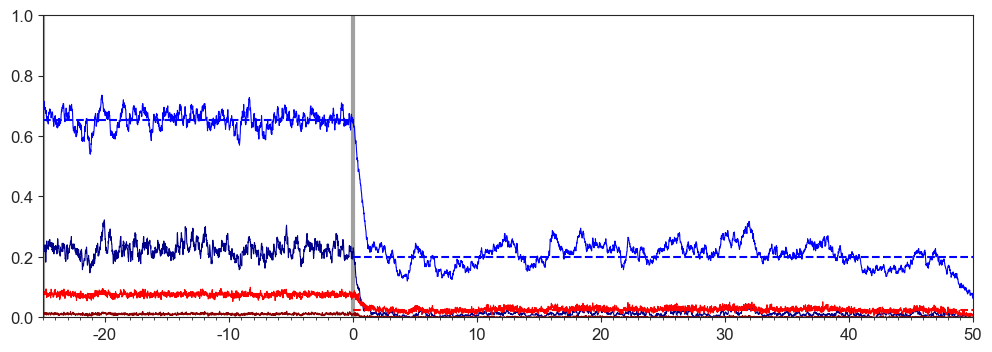

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

prevalence_trajectory_plot(ot, epoch_df, ax,
                           norm_t0=("Crash", "t0"),
                           indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("Recovery", "t0")],
                           indicate_equilibriums=["InitVar", "Crash", "CrashVar", "Recovery"],
                            time_limits=epoch_df.loc["InitVar", "t0"] + (0, 75*365),
                           years_per_major_tick=10)

### Prevalence, Recovery

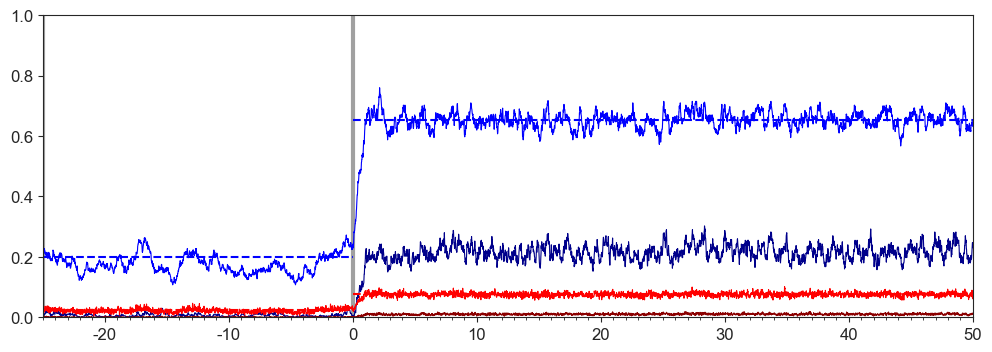

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

prevalence_trajectory_plot(ot, epoch_df, ax,
                           norm_t0=("Recovery", "t0"),
                           indicate_epochs=[("CrashVar", "t0"), ("Recovery", "t0")],
                           indicate_equilibriums=["InitVar", "Crash", "CrashVar", "Recovery"],
                           time_limits=epoch_df.loc["CrashVar", "t0"] + (0, 75*365),
                           years_per_major_tick=10)

### Genetics, Crash

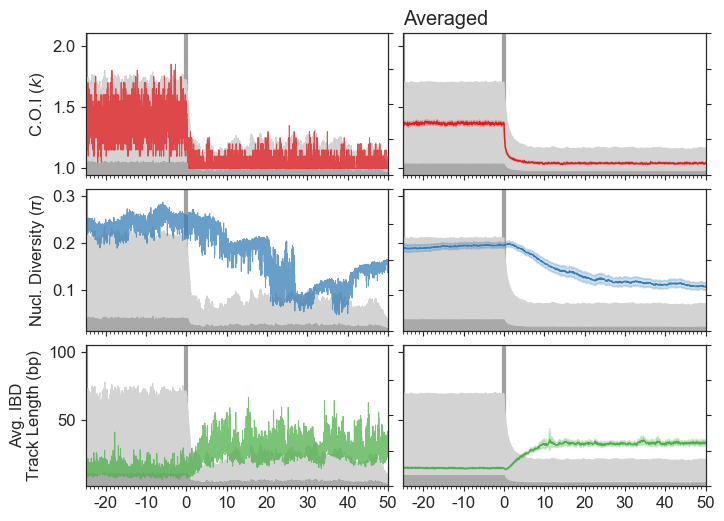

In [12]:
metrics = ["mean_k", "pi", "avg_l_ibd"]
metric_cols = sns.color_palette("Set1", len(metrics))
col_dt = dict(zip(metrics, metric_cols))
n_metrics = len(metrics)

fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for i, metric in enumerate(metrics):
    
    # Raw
    genetic_trajectory_plot(metric, ot, epoch_df,
                            col_dt[metric], ax[i, 0],
                            norm_t0=("Crash", "t0"),
                            indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("CrashVar", "t0")],
                            time_limits=epoch_df.loc["InitVar", "t0"] + (0, 75*365),
                            t_detection=None,
                            t_equilibrium=None,
                            years_per_major_tick=10)
    
    # Surface
    genetic_trajectory_average_plot(metric, ot_mu, ot_se, epoch_df,
                                    col_dt[metric], ax[i, 1],
                                    norm_t0=("Crash", "t0"),
                                    indicate_epochs=[("Crash", "t0"), ("InitVar", "t0"), ("CrashVar", "t0")],
                                    time_limits=epoch_df.loc["InitVar", "t0"] + (0, 75*365),
                                    years_per_major_tick=10)

    # y
    ax[i, 0].set_ylabel(genetic_names[metric], fontsize=12)
    ax[i, 1].set_ylabel("")
    
    ax[0, 0].set_title("", loc="left")
    ax[0, 1].set_title("Averaged", loc="left")

### Genetics, Recovery

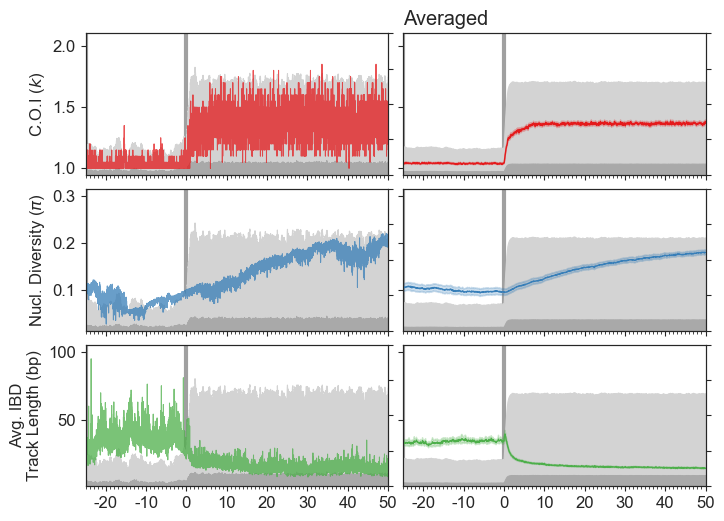

In [13]:
metrics = ["mean_k", "pi", "avg_l_ibd"]
metric_cols = sns.color_palette("Set1", len(metrics))
col_dt = dict(zip(metrics, metric_cols))
n_metrics = len(metrics)

fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for i, metric in enumerate(metrics):
    
    # Raw
    genetic_trajectory_plot(metric, ot, epoch_df,
                            col_dt[metric], ax[i, 0],
                            norm_t0=("Recovery", "t0"),
                            indicate_epochs=[("CrashVar", "t0"), ("Recovery", "t0")],
                            time_limits=epoch_df.loc["CrashVar", "t0"] + (0, 75*365),
                            t_detection=None,
                            t_equilibrium=None,
                            years_per_major_tick=10)
    
    # Surface
    genetic_trajectory_average_plot(metric, ot_mu, ot_se, epoch_df,
                                    col_dt[metric], ax[i, 1],
                                    norm_t0=("Recovery", "t0"),
                                    indicate_epochs=[("CrashVar", "t0"), ("Recovery", "t0")],
                                    time_limits=epoch_df.loc["CrashVar", "t0"] + (0, 75*365),
                                    years_per_major_tick=10)

    # y
    ax[i, 0].set_ylabel(genetic_names[metric], fontsize=12)
    ax[i, 1].set_ylabel("")
    
    ax[0, 0].set_title("", loc="left")
    ax[0, 1].set_title("Averaged", loc="left")

## All in one plot?